# Introducción

El objetivo de este trabajo es **predecir la calificación final de estudiantes de un curso** a partir de su información demográfica y de las calificaciones de los primeros 2 de 3 periodos de evaluación, utilizando un modelo de MLR. Los datos se descargaron originalmente del *Student Performance Data Set* en el *UCI Machine Learning Repository*.

Estas son las categorías de la base de datos:
- **Escuela**: Indica si el estudiante en cuestión asistió a la escuela Gabriel Pereira (GP) o
a la escuela Mousinho da Silveira (MS).
- **Sexo**: F para mujeres y H para hombres.
- **Edad**: Edad del estudiante, en años.
- **HorasDeEstudio**: Cantidad de horas de estudio: 1 indica menos de dos horas, 2
indica de dos a cinco horas, 3 indica de cinco a diez horas, 4 indica más de diez horas.
- **Reprobadas**: Indica la cantidad de materias reprobadas previamente.
- **Internet**: Si el estudiante tenía acceso (yes) o no (no) a internet en su casa.
- **Faltas**: Cantidad de veces que faltó a clases.
- **G1**: Calificación del primer periodo, escala del 0 al 20.
- **G2**: Calificación del segundo periodo, escala del 0 al 20.
- **G3**: Calificación final, escala del 0 al 20.

# Análisis

## Exploracion de datos

Primero se lee el archivo `Calificaciones.csv` y observaremos el tipo de dato que tiene cada categoría. Conociendo los datos con los que se trabaja es que podemos asegurarnos que están listos para utilizarse en un modelo de aprendizaje automático.

In [161]:
# Preámbulo -- librerías
import pandas as pd
import numpy as np
from seaborn import heatmap
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [162]:
# lectura de archivo
df = pd.read_csv('Calificaciones.csv')
print(f"Vistazo preliminar: \n\n {df.head()}")
print(f"\n Tipos de datos: \n\n {df.dtypes}")

Vistazo preliminar: 

   Escuela Sexo  Edad  HorasDeEstudio  Reprobadas Internet  Faltas  G1  G2  G3
0      GP    F    18               2           0       no       6   5   6   6
1      GP    F    17               2           0      yes       4   5   5   6
2      GP    F    15               2           3      yes      10   7   8  10
3      GP    F    15               3           0      yes       2  15  14  15
4      GP    F    16               2           0       no       4   6  10  10

 Tipos de datos: 

 Escuela           object
Sexo              object
Edad               int64
HorasDeEstudio     int64
Reprobadas         int64
Internet          object
Faltas             int64
G1                 int64
G2                 int64
G3                 int64
dtype: object


## Transformación de datos categóricos

Como se puede apreciar, los tipos de datos son los esperados. Por tanto, podemos empezar la **transformación de datos categóricos** (aun si son numéricos) **en datos booleanos** a través de *one-hot encoding* para que sean variables que nuestro modelo de MLR pueda manipular correctamente. En este caso, las categorías a transformar serían: `Escuela`, `Sexo`, `HorasDeEstudio` e `Internet`

In [163]:
# obtener indices de datos categóricos
nombresDatosCategoricos = ["Escuela", "Sexo", "HorasDeEstudio", "Internet"]
indicesDatosCategoricos = df.columns.get_indexer(nombresDatosCategoricos)

# agregar 'l-1' variables dummy booleanas por cada variable categórica
for i in indicesDatosCategoricos:
    dummy = pd.get_dummies(df.iloc[:,i],drop_first=True)
    df = pd.concat([df,dummy],axis=1)

# quitar los datos categóricos y mostrar nuevo df
df = df.drop(nombresDatosCategoricos,axis=1)
print(f"Vista preliminar: \n\n {df.head()}")

Vista preliminar: 

    Edad  Reprobadas  Faltas  G1  G2  G3     MS      M      2      3      4  \
0    18           0       6   5   6   6  False  False   True  False  False   
1    17           0       4   5   5   6  False  False   True  False  False   
2    15           3      10   7   8  10  False  False   True  False  False   
3    15           0       2  15  14  15  False  False  False   True  False   
4    16           0       4   6  10  10  False  False   True  False  False   

     yes  
0  False  
1   True  
2   True  
3   True  
4  False  


Como puede verse, ahora solo tenenmos valores numéricos y booleanos en la base de datos. De acuerdo con el orden en el que se fueron agregando las variables dummy:

- `MS` corresponde a si alguien fue a Mousinho da Silva o no
- `M` indica si el estudiante es hombre (male) o no
- `2`, `3`, y `4` representan rangos de horas de estudio; si en todos hay un valor falso, entendemos que el estudiante entra en la categoría `1`.
- `yes` nos muestra si el estudiante tenía o no internet


## Valores atípicos


Ahora podemos explorar valores atípicos. En este caso exploraré los valores de `Faltas` a través del Método de Tukey, para determinar si vale la pena examinarse en más profundidad

In [164]:
# Variables de interés del método
q1 = df.Faltas.quantile(0.25)
q3 = df.Faltas.quantile(0.75)
iqr = q3 - q1
limiteInferior = q1 - 1.5*iqr
limiteSuperior = q3 + 1.5*iqr

# Observaciones fuera de los límites
outliers = df.loc[(df.Faltas < limiteInferior) | (df.Faltas > limiteSuperior), "Faltas"].values
print(outliers)

[25 54 26 56 24 28 22 21 75 22 30 38 22 40 23]


Dado que el estudio se realizó en estudiantes de preparatoria de Portugal, es notable ver que sus ciclos de estudio parecen ser de 1 año, con tres trimestres, cuando en México la preparatoria se realiza por semestres.

Aun así, dejando un valor aproximado de  2 meses y medio de vacaciones, menos 8 días (fines de semana) por cada mes efectivo de clases (con promedio de 30 días), pueden considerarse aproximadamente $9.5
\cdot 22 = 209$ días hábiles escolares.

Dado que no hay valores de faltas como 150 o parecidos, **no eliminaré los outliers encontrados**. Sirve y se encuentra información interesante con los estudiantes con números de faltas superiores a los esperados.

## Colinealidad

Ahora realizaré una matriz de correlaciones para detectar posibles problemas con colinealidad (información muy similar entre variables), buscando valores máximos y decidir si remover alguno de ellos o no

Indices: 4, 5
Correlacion Maxima: 0.904867989269301


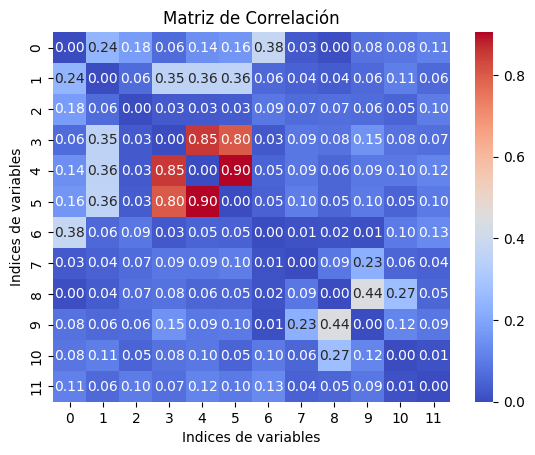

In [165]:
# Se convierten valores booleanos en numéricos para el heatmap
bool_cols = df.select_dtypes(include='bool').columns
for col in bool_cols:
    df[col] = df[col].astype(int)

# Matriz de correlacion; llenarla de ceros
cor = abs(np.corrcoef(df,rowvar=False))
np.fill_diagonal(cor,0)

# Encontrar índices de posiciónd del valor máximo
i, j = np.unravel_index(cor.argmax(),cor.shape)
print(f"Indices: {i}, {j}")
print(f"Correlacion Maxima: {cor[i, j]}")
heatmap(cor, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Matriz de Correlación")  # Title
plt.xlabel("Indices de variables")  # X-axis label
plt.ylabel("Indices de variables")  # Y-axis label
plt.show()

La mayor correlación fue la de los índices que corresponden a las variables `G2`y `G3`. Sin embargo, dado que la colinealidad no es superior, y dado que es podría ser valioso observar la relación entre las calificaciones en segundo trimestre y las del tercer trimestre, **no se eliminará ninguna variable**




## Interacciones entre variables

Ahora es pertinente **explorar interacciones entre variables**. En mi caso, me interesa 1) ver relación entre sexo y faltas y 2) la interacción edad y faltas. Alguna de ellas afecta el número de faltas? Para esto, sin embargo, necesitamos empezar a separar datos de entrenamiento y datos de prueba, luego generar las interacciones

In [166]:
# conjuntos de datos
xTrain, xTest, yTrain, yTest = train_test_split(df.drop('G3',axis=1),df['G3'],test_size=0.2)
xTrain.columns = xTrain.columns.astype(str) # para que no me grite el intérprete
# generar interacciones
xTrain.insert(11,"M Faltas",xTrain.M*xTrain.Faltas)
xTest.insert(11,"M Faltas",xTest.M*xTest.Faltas)
xTrain.insert(12, "Edad Faltas",xTrain.Edad*xTrain.Faltas)
xTest.insert(12, "Edad Faltas",xTest.Edad*xTest.Faltas)
print(xTrain.head())
print(xTest.head())

     Edad  Reprobadas  Faltas  G1  G2  MS  M  2  3  4  yes  M Faltas  \
308    19           1       0  15  12   0  1  1  0  0    0         0   
379    17           0      17  10  10   1  0  1  0  0    1         0   
45     15           0       8   8   8   0  0  1  0  0    1         0   
240    17           0      14  12  12   0  1  1  0  0    1        14   
171    16           0       2  13  15   0  1  1  0  0    1         2   

     Edad Faltas  
308            0  
379          289  
45           120  
240          238  
171           32  
     Edad  Reprobadas  Faltas  G1  G2  MS  M  2  3  4  yes  M Faltas  \
247    22           3      16   6   8   0  1  0  0  0    1        16   
144    17           3       0   5   0   0  1  0  0  0    1         0   
296    19           0       0  10   9   0  0  1  0  0    1         0   
152    15           2       8  10  10   0  0  0  1  0    1         0   
175    17           0       4  10   9   0  1  1  0  0    1         4   

     Edad Faltas  
2

# Resultados del entrenamiento y discusiones

Ahora, con las interacciones generadas, podemos proceder a entrenar el modelo de MLR a través de OLS, y evaluar la eficacia del modelo para predecir las calificaciones del último trimestre.

In [167]:
# Entrenar modelo
results = sm.OLS(yTrain, sm.add_constant(xTrain)).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                     G3   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     152.0
Date:                Mon, 10 Feb 2025   Prob (F-statistic):          5.43e-124
Time:                        01:43:30   Log-Likelihood:                -610.06
No. Observations:                 316   AIC:                             1248.
Df Residuals:                     302   BIC:                             1301.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.0278      1.860      1.090      

Desde aquí se puede ver algo interesante: solo `G1` y `G2` tienen valores p tal que $p < 0.05$, por lo que solo de estos podemos encontrar que tienen una relación estadísticamente significativa con la variable de salida. Además, `Faltas`, la cual fue de las variables más exploradas en este trabajo, tiene un 85% de probabilidad de **no** tener impacto en la variable de salida.

La $R^2$ ajustada es mayor a $0.8$, lo cual nos muestra que de todos modos el modelo as adecuado para explicar la mayor parte del comportamiento de la variable de salida. Esto lo podemos apreciar en la siguiente gráfica:

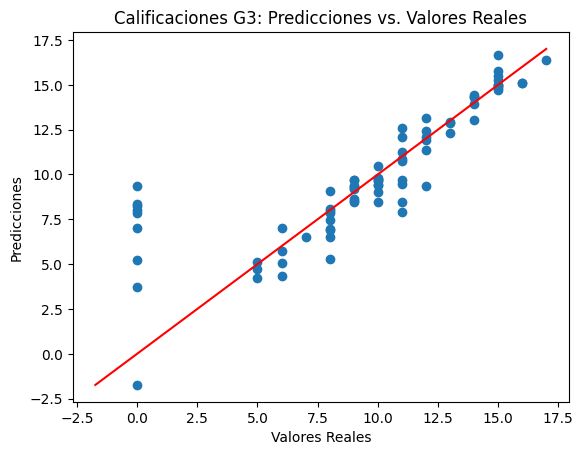

In [168]:
# Predicciones con datos de prueba
yHat = results.predict(sm.add_constant(xTest))

# Grafica de línea con pendiente 1
min_val = min(min(yTest), min(yHat))
max_val = max(max(yTest), max(yHat))

# Grafica de predicciones contra valores reales
plt.scatter(yTest,yHat)
plt.plot([min_val, max_val], [min_val, max_val], color="red")
plt.title("Calificaciones G3: Predicciones vs. Valores Reales")
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.show()

Esta gráfica nos muestra algo interesante: hay datos de prueba que son $0$ cuando el modelo predice calificaciones más grandes. Curiosamente, solamente en los valores reales de $0$ es cuando hay mucha discrepancia (de forma cualitativa) entre los valores reales y las predicciones del modelo.

Posiblemente la exploración de valores atípicos en variables diferentes a `Faltas` podría ayudar en eliminar observaciones inusuales que perjudiquen el *performance* del modelo (en caso de que sea pertinente removerlas). También explorar interacciones adicionales podría ayudar.

De todos modos, cabe recalcar que el modelo tuvo una $R^2_{adj} > 0.86$, por lo que se puede decir que **es adecuado para explicar en general la calificación del tercer trimestre del ciclo escolar portugués en preparatorias** dadas las variables de entrada consideradas.

Por último, como trabajo futuro, podrían usarse metodologías como SFS/SBS para reducir el número de variables usadas para el modelo. Después de todo, solo dos variables tuvieron una asociación significativa a la variable de salida, por lo que valdría la pena emplear estos métodos para ocasiones futuras.
